## 卷积后的维度= (卷积前的维度-卷积核边长+ 2* padding)/步长+1
[](pictures/Yolov5_CSPT.png)
<img src=pictures/Yolov5_CSPT.png width = 500>

In [26]:
import torch
from torch import nn

class CSPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(64, 32, 1, 1, 0), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 1, 1, 0), nn.ReLU(),
                                   nn.Conv2d(32, 32, 1, 1, 0), nn.ReLU())
        self.final_conv = nn.Sequential(nn.Conv2d(64, 64, 1, 1, 0), nn.ReLU())

        
    def forward(self, input):
        # 64-->32
        path1 = self.conv1(input)

        # (32-->32) * 2
        path2 = self.conv2(path1)

        # Add
        added = path1 + path2

        # 将相加后的结果与输入拼接 (concat) 在通道维度上
        concatenated = torch.cat((path1, added), dim=1)  # 输出维度：[B, 64, H, W]

        # 最终通过一个 1x1 卷积来压缩通道数
        output = self.final_conv(concatenated)

        return output
        

# 测试模型
if __name__ == "__main__":
    mynn = CSPT()
    sample_input = torch.randn(1, 64, 80, 80)  # 输入张量 (Batch, Channels, Height, Width)
    output = mynn(sample_input)
    print(output.shape)  # 输出张量形状应为 (1, 64, 80, 80)

torch.Size([1, 64, 80, 80])


[](attachment:b929920f-53d3-4395-82b6-64117f4f2a1e.png)
<img src=attachment:b929920f-53d3-4395-82b6-64117f4f2a1e.png width=500>
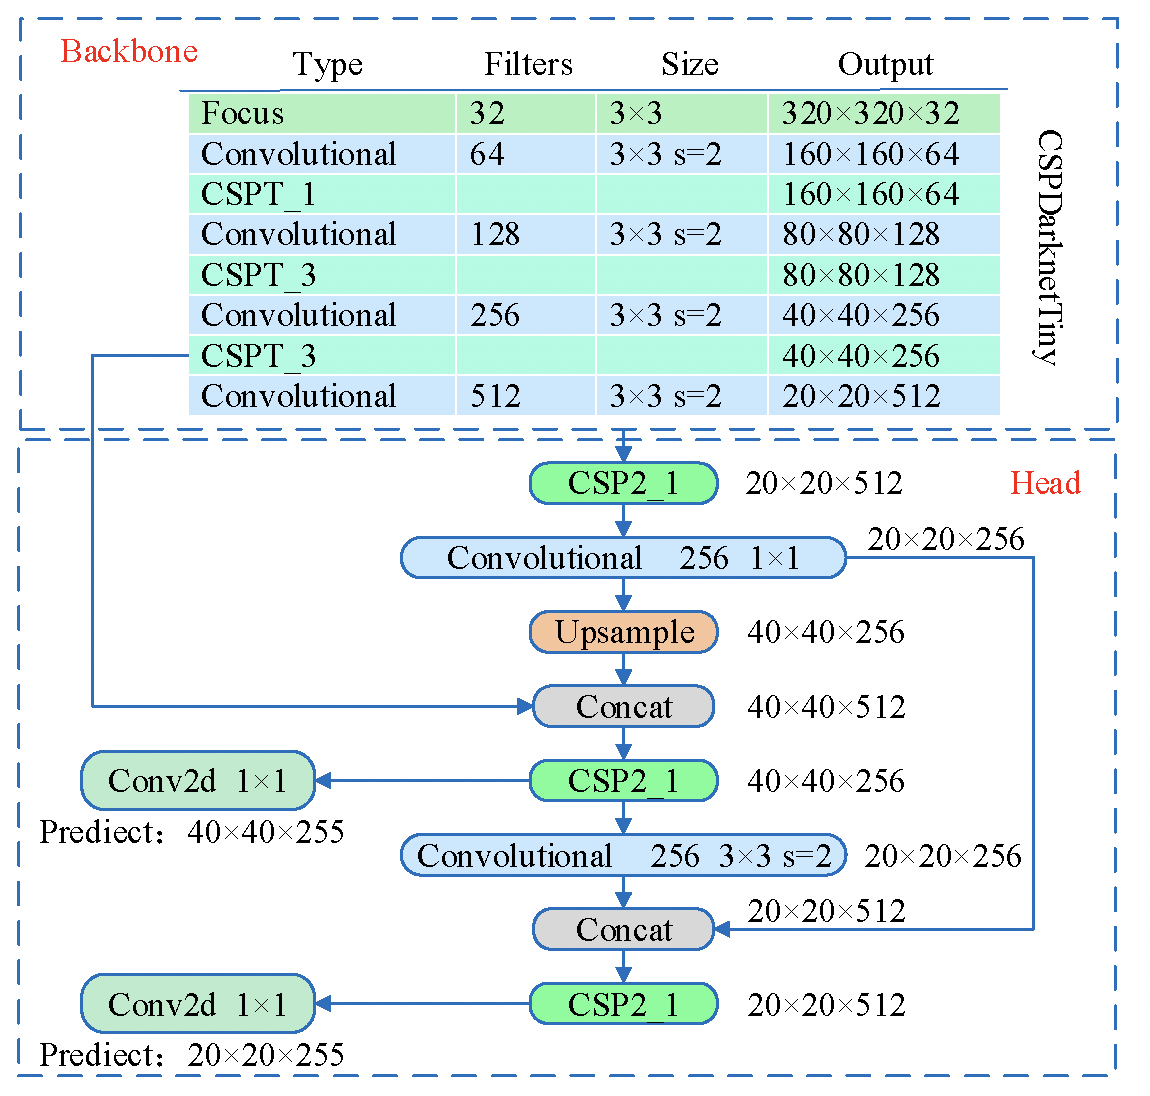

In [18]:
import torch
from torch import nn

class Focus(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Focus, self).__init__()
        # Adjust in_channels for the sliced output (in_channels * 4)
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        # Slice and rearrange the input tensor
        patch_top_left = x[..., ::2, ::2]
        patch_top_right = x[..., ::2, 1::2]
        patch_bottom_left = x[..., 1::2, ::2]
        patch_bottom_right = x[..., 1::2, 1::2]

        # Concatenate along the channel dimension
        x = torch.cat((patch_top_left, patch_top_right, patch_bottom_left, patch_bottom_right), dim=1)
        return self.act(self.bn(self.conv(x)))


class CSPT(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CSPT, self).__init__()
        # 主分支：1x1卷积降维
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        # 残差路径：两个1x1卷积
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )
        # 最终的1x1卷积：处理拼接后的通道数
        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        path1 = self.conv1(x)  # 输出：80x80x32
        path2 = self.conv2(path1)  # 输出：80x80x32
        added = path1 + path2  # 相加后的尺寸：80x80x32
        concatenated = torch.cat((path1, added), dim=1)  # 拼接后的尺寸：80x80x64
        output = self.final_conv(concatenated)  # 输出：80x80x32
        return output


class YOLOv5Tiny(nn.Module):
    def __init__(self, num_classes=80):
        super(YOLOv5Tiny, self).__init__()
        
        # Backbone
        self.focus = Focus(3, 32)
        self.conv1 = nn.Conv2d(32, 64, 3, 2, 1)
        self.csp1 = CSPT(64, 64)
        self.conv2 = nn.Conv2d(64, 128, 3, 2, 1)
        self.csp2 = CSPT(128, 128)
        self.conv3 = nn.Conv2d(128, 256, 3, 2, 1)
        self.csp3 = CSPT(256, 256)
        self.conv4 = nn.Conv2d(256, 512, 3, 2, 1)

        # Head 部分 (FPN+PAN)
        self.csp4 = CSPT(512, 512)
        self.conv5 = nn.Conv2d(512, 256, 1, 1, 0)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.concat1 = nn.Conv2d(512, 256, 1, 1, 0)
        self.csp5 = CSPT(256, 256)
        self.pred1 = nn.Conv2d(256, num_classes + 5, 1, 1, 0)

        self.conv6 = nn.Conv2d(256, 256, 3, 2, 1)
        self.concat2 = nn.Conv2d(768, 512, 1, 1, 0)
        self.csp6 = CSPT(512, 512)
        self.pred2 = nn.Conv2d(512, num_classes + 5, 1, 1, 0)

    def forward(self, x):
        # Backbone 部分
        x = self.focus(x)
        x = self.conv1(x)
        x = self.csp1(x)
        x = self.conv2(x)
        x = self.csp2(x)
        x = self.conv3(x)
        p3 = self.csp3(x)
        x = self.conv4(p3)
        p4 = self.csp4(x)

        # Head 部分
        x = self.conv5(p4)
        x = self.upsample(x)

        x = torch.cat((x, p3), dim=1)
        x = self.concat1(x)
        p5 = self.csp5(x)
        pred1 = self.pred1(p5)

        x = self.conv6(p5)
        x = torch.cat((x, p4), dim=1)
        x = self.concat2(x)
        p6 = self.csp6(x)
        pred2 = self.pred2(p6)

        return pred1, pred2

# 测试 YOLOv5 Tiny 模型
if __name__ == "__main__":
    model = YOLOv5Tiny(num_classes=80)
    sample_input = torch.randn(1, 3, 640, 640)  # Batch size 1, RGB image of size 640x640
    output1, output2 = model(sample_input)
    print(output1.shape)  # Should be (1, 85, 40, 40)
    print(output2.shape)  # Should be (1, 85, 20, 20)



torch.Size([1, 85, 40, 40])
torch.Size([1, 85, 20, 20])
